# Exploratory Data Analysis

This notebook explores the data for implementing the approach described in Yang and Malik (2024): "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach". We're using BTCUSDT and ETHUSDT as our trading pair.

## 1. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
import os
%matplotlib inline

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')

# Create docs directory for saving plots
os.makedirs('docs', exist_ok=True)

In [3]:
print("Files in current directory:", os.listdir())
print("Current working directory:", os.getcwd())

Files in current directory: ['BackTest.ipynb', 'Week 3 Notebook.ipynb', 'docs', 'exploratory_data_analysis.ipynb']
Current working directory: /Users/freddieliang/Desktop/RL-Pairs-Trading-Replication/notebooks


## 2. Load Data

We'll use the BTCUSDT and ETHUSDT 1-minute data collected from Binance.US API.

In [4]:
# Load the data
try:
    # Go up one directory level and then into 'data'
    btcusdt = pd.read_csv('../data/btcusdt_1m_raw.csv')
    ethusdt = pd.read_csv('../data/ethusdt_1m_raw.csv')

    # Basic data exploration
    print("BTCUSDT data shape:", btcusdt.shape)
    print("ETHUSDT data shape:", ethusdt.shape)

    print("\nBTCUSDT first 5 rows:")
    display(btcusdt.head())
    
    print("\nETHUSDT first 5 rows:")
    display(ethusdt.head())
except FileNotFoundError as e:
    print(f"Data files not found: {e}")
    print("Please run the data collection script first.")

BTCUSDT data shape: (131101, 13)
ETHUSDT data shape: (131101, 13)

BTCUSDT first 5 rows:


,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_base_volume,taker_buy_quote_volume,ignore,datetime
0,1696143600000,27095.01,27095.01,27095.01,27095.01,0.00071,1696143659999,19.237457,1,0.00000,0.00000,0,2023-10-01 07:00:00
1,1696143660000,27105.00,27105.00,27105.00,27105.00,0.00079,1696143719999,21.412950,2,0.00079,21.41295,0,2023-10-01 07:01:00
2,1696143720000,27105.00,27105.00,27105.00,27105.00,0.00072,1696143779999,19.515600,2,0.00072,19.51560,0,2023-10-01 07:02:00
3,1696143780000,27105.00,27105.00,27105.00,27105.00,0.00000,1696143839999,0.000000,0,0.00000,0.00000,0,2023-10-01 07:03:00
4,1696143840000,27105.00,27105.00,27105.00,27105.00,0.00160,1696143899999,43.368000,1,0.00160,43.36800,0,2023-10-01 07:04:00



ETHUSDT first 5 rows:


,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_base_volume,taker_buy_quote_volume,ignore,datetime
0,1696143600000,1677.56,1677.56,1677.56,1677.56,0.0,1696143659999,0.0,0,0.0,0.0,0,2023-10-01 07:00:00
1,1696143660000,1677.56,1677.56,1677.56,1677.56,0.0,1696143719999,0.0,0,0.0,0.0,0,2023-10-01 07:01:00
2,1696143720000,1677.56,1677.56,1677.56,1677.56,0.0,1696143779999,0.0,0,0.0,0.0,0,2023-10-01 07:02:00
3,1696143780000,1677.56,1677.56,1677.56,1677.56,0.0,1696143839999,0.0,0,0.0,0.0,0,2023-10-01 07:03:00
4,1696143840000,1677.56,1677.56,1677.56,1677.56,0.0,1696143899999,0.0,0,0.0,0.0,0,2023-10-01 07:04:00


## 3. Data Preparation

Let's prepare the data for analysis by ensuring datetime indexes and proper data types.

In [5]:
# Convert timestamp to datetime if not already done
btcusdt['datetime'] = pd.to_datetime(btcusdt['datetime'])
ethusdt['datetime'] = pd.to_datetime(ethusdt['datetime'])

# Set datetime as index
btcusdt.set_index('datetime', inplace=True)
ethusdt.set_index('datetime', inplace=True)

# Check data info
print("BTCUSDT date range:", btcusdt.index.min(), "to", btcusdt.index.max())
print("ETHUSDT date range:", ethusdt.index.min(), "to", ethusdt.index.max())

BTCUSDT date range: 2023-10-01 07:00:00 to 2023-12-31 08:00:00
ETHUSDT date range: 2023-10-01 07:00:00 to 2023-12-31 08:00:00


## 4. Basic Statistics

In [6]:
# Calculate basic statistics
btc_stats = btcusdt['close'].describe()
eth_stats = ethusdt['close'].describe()

stats_df = pd.DataFrame({
    'BTC-USDT': btc_stats,
    'ETH-USDT': eth_stats
})

# Display statistics
display(stats_df)

# Calculate returns
btcusdt['returns'] = btcusdt['close'].pct_change()
ethusdt['returns'] = ethusdt['close'].pct_change()

# Calculate return statistics
btc_return_stats = btcusdt['returns'].describe()
eth_return_stats = ethusdt['returns'].describe()

return_stats_df = pd.DataFrame({
    'BTC-USDT Returns': btc_return_stats,
    'ETH-USDT Returns': eth_return_stats
})

# Display return statistics
display(return_stats_df)

,BTC-USDT,ETH-USDT
count,131101.000000,131101.000000
mean,36153.724578,1963.243713
std,5600.296239,259.728637
min,26557.430000,1523.000000
25%,33523.230000,1763.120000
50%,36690.600000,2013.900000
75%,41866.520000,2214.780000
max,44697.550000,2438.670000


,BTC-USDT Returns,ETH-USDT Returns
count,131100.000000,131100.000000
mean,0.000004,0.000003
std,0.000590,0.000676
min,-0.016229,-0.024534
25%,-0.000246,0.000000
50%,0.000000,0.000000
75%,0.000266,0.000000
max,0.010638,0.010611


## 5. Price Visualization

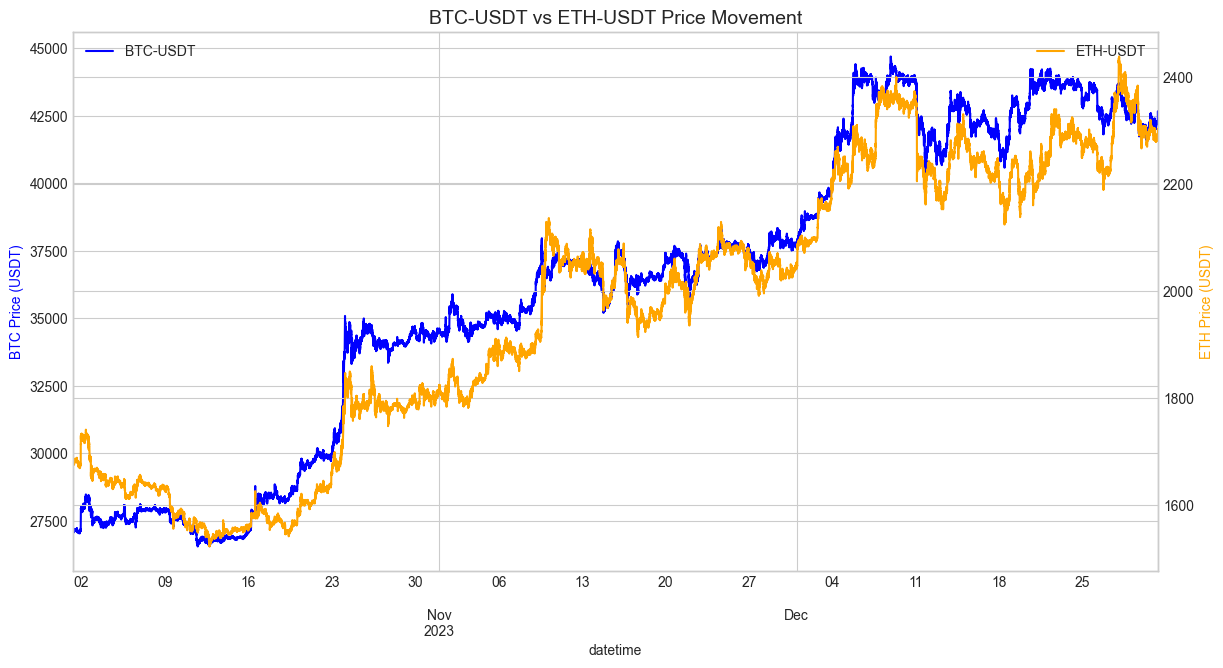

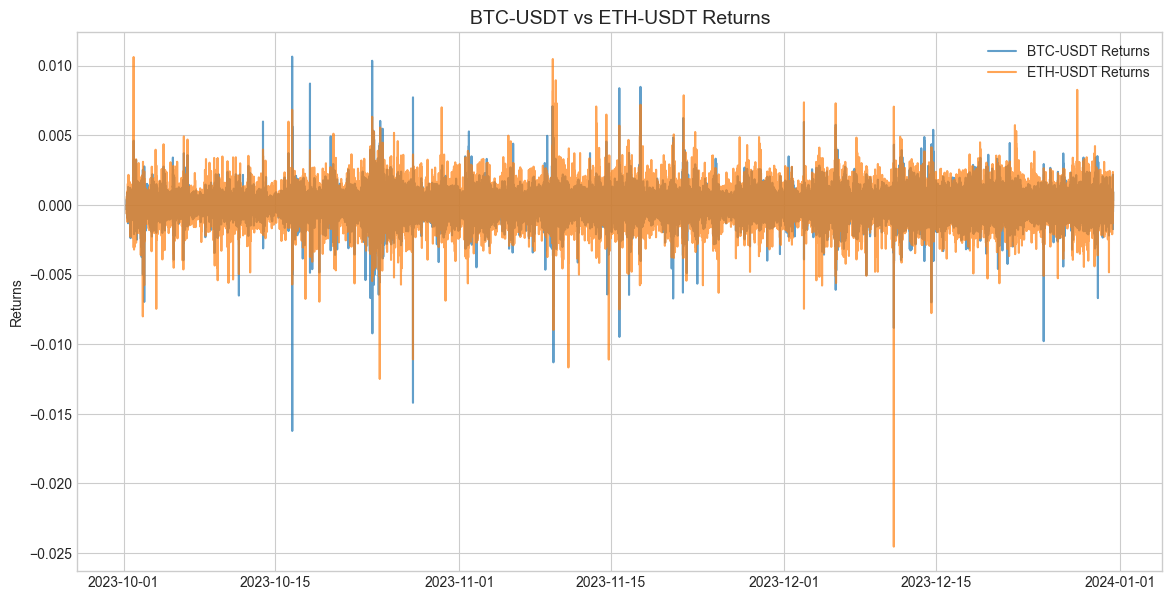

In [7]:
# Visualize price movements
plt.figure(figsize=(14, 7))

# Create two y-axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot BTC on left axis
btcusdt['close'].plot(ax=ax1, color='blue', label='BTC-USDT')
ax1.set_ylabel('BTC Price (USDT)', color='blue')

# Plot ETH on right axis
ethusdt['close'].plot(ax=ax2, color='orange', label='ETH-USDT')
ax2.set_ylabel('ETH Price (USDT)', color='orange')

# Add title and legend
plt.title('BTC-USDT vs ETH-USDT Price Movement', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save and show
plt.savefig('docs/price_movement.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot returns
plt.figure(figsize=(14, 7))
plt.plot(btcusdt['returns'].dropna(), label='BTC-USDT Returns', alpha=0.7)
plt.plot(ethusdt['returns'].dropna(), label='ETH-USDT Returns', alpha=0.7)
plt.title('BTC-USDT vs ETH-USDT Returns', fontsize=14)
plt.ylabel('Returns')
plt.legend()
plt.savefig('docs/returns.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Correlation and Cointegration Analysis

Price correlation between BTC-USDT and ETH-USDT: 0.9783
Returns correlation between BTC-USDT and ETH-USDT: 0.3301
Cointegration p-value: 0.0413
Pairs are cointegrated at 5% significance level


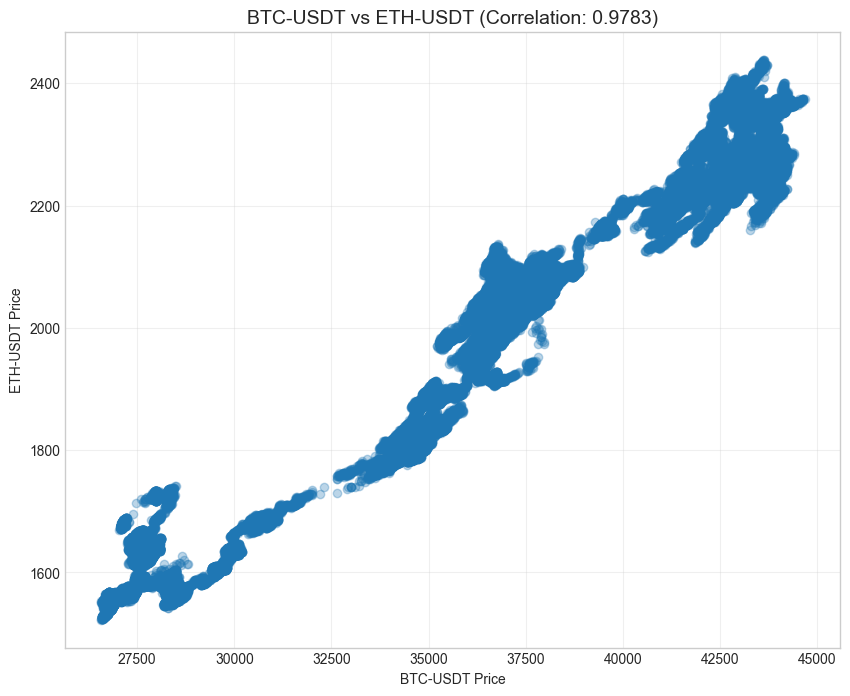

In [8]:
# Ensure we're working with common timestamps
common_index = btcusdt.index.intersection(ethusdt.index)
btc_aligned = btcusdt.loc[common_index]['close']
eth_aligned = ethusdt.loc[common_index]['close']

# Calculate price correlation
price_correlation = btc_aligned.corr(eth_aligned)
print(f"Price correlation between BTC-USDT and ETH-USDT: {price_correlation:.4f}")

# Calculate returns correlation
btc_returns_aligned = btcusdt.loc[common_index]['returns'].dropna()
eth_returns_aligned = ethusdt.loc[common_index]['returns'].dropna()
common_return_index = btc_returns_aligned.index.intersection(eth_returns_aligned.index)
returns_correlation = btc_returns_aligned.loc[common_return_index].corr(eth_returns_aligned.loc[common_return_index])
print(f"Returns correlation between BTC-USDT and ETH-USDT: {returns_correlation:.4f}")

# Test for cointegration
score, pvalue, _ = coint(btc_aligned.dropna(), eth_aligned.dropna())
print(f"Cointegration p-value: {pvalue:.4f}")
print(f"Pairs are {'cointegrated' if pvalue < 0.05 else 'not cointegrated'} at 5% significance level")

# Plot correlation
plt.figure(figsize=(10, 8))
plt.scatter(btc_aligned, eth_aligned, alpha=0.3)
plt.title(f'BTC-USDT vs ETH-USDT (Correlation: {price_correlation:.4f})', fontsize=14)
plt.xlabel('BTC-USDT Price')
plt.ylabel('ETH-USDT Price')
plt.grid(True, alpha=0.3)
plt.savefig('docs/correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Price Ratio and Spread Analysis

For pair trading, we need to examine the spread or ratio between the two assets.

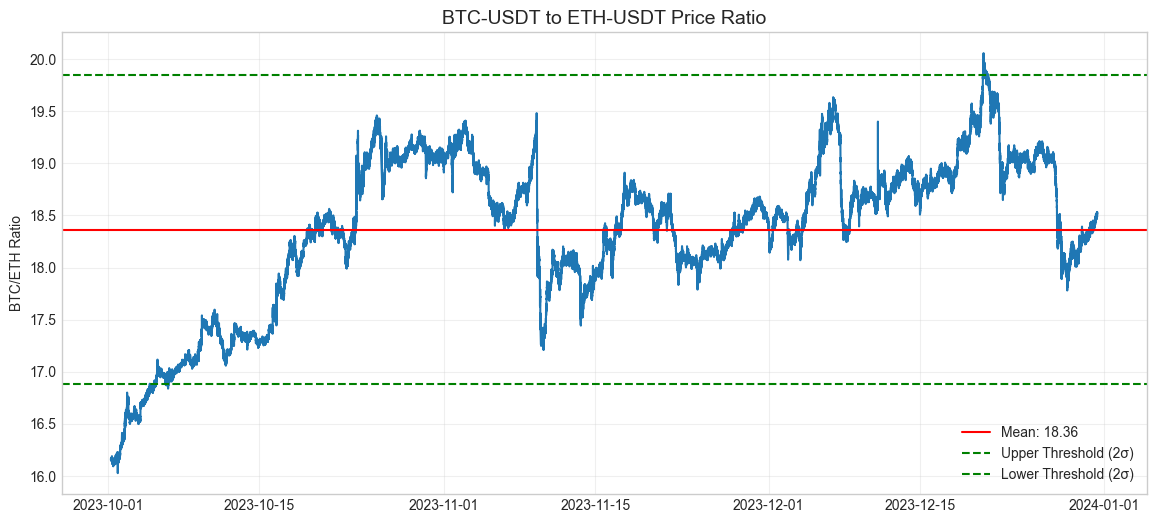

ADF Statistic: -3.1431
p-value: 0.0235
The log ratio is stationary at 5% significance level


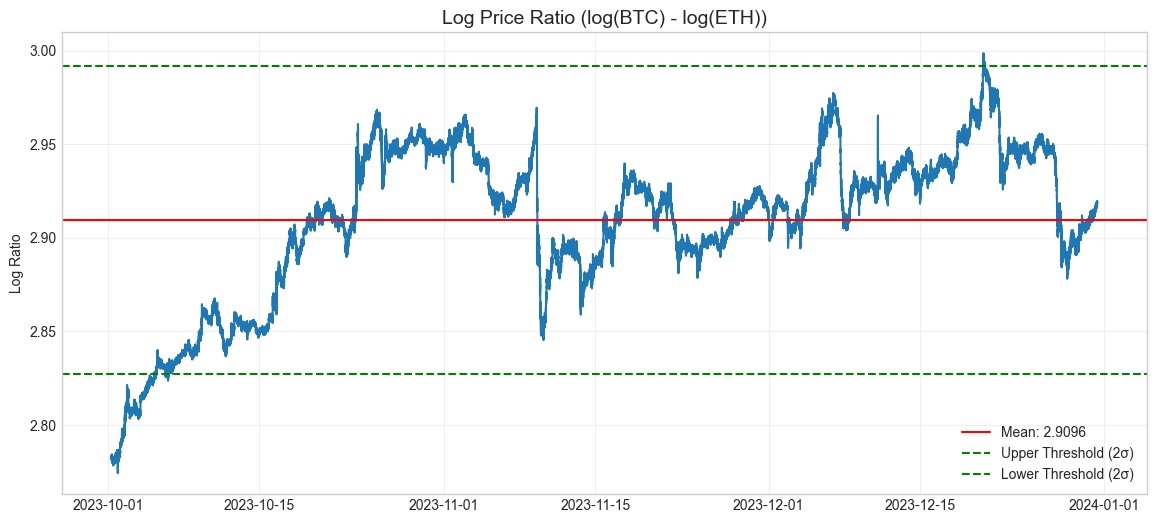

In [9]:
# Calculate price ratio (BTC/ETH)
price_ratio = btc_aligned / eth_aligned

# Visualize price ratio
plt.figure(figsize=(14, 6))
plt.plot(price_ratio)
plt.title('BTC-USDT to ETH-USDT Price Ratio', fontsize=14)
plt.ylabel('BTC/ETH Ratio')
plt.axhline(y=price_ratio.mean(), color='r', linestyle='-', label=f'Mean: {price_ratio.mean():.2f}')
plt.axhline(y=price_ratio.mean() + 2*price_ratio.std(), color='g', linestyle='--', label='Upper Threshold (2σ)')
plt.axhline(y=price_ratio.mean() - 2*price_ratio.std(), color='g', linestyle='--', label='Lower Threshold (2σ)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/price_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate log price ratio (log(BTC) - log(ETH))
log_ratio = np.log(btc_aligned) - np.log(eth_aligned)

# Test log ratio for stationarity (Augmented Dickey-Fuller test)
adf_result = adfuller(log_ratio.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"The log ratio is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'} at 5% significance level")

# Visualize log ratio
plt.figure(figsize=(14, 6))
plt.plot(log_ratio)
plt.title('Log Price Ratio (log(BTC) - log(ETH))', fontsize=14)
plt.ylabel('Log Ratio')
plt.axhline(y=log_ratio.mean(), color='r', linestyle='-', label=f'Mean: {log_ratio.mean():.4f}')
plt.axhline(y=log_ratio.mean() + 2*log_ratio.std(), color='g', linestyle='--', label='Upper Threshold (2σ)')
plt.axhline(y=log_ratio.mean() - 2*log_ratio.std(), color='g', linestyle='--', label='Lower Threshold (2σ)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/log_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Z-Score Calculation for Pair Trading

Following the methodology in the paper, we'll calculate the z-score using a rolling window approach.

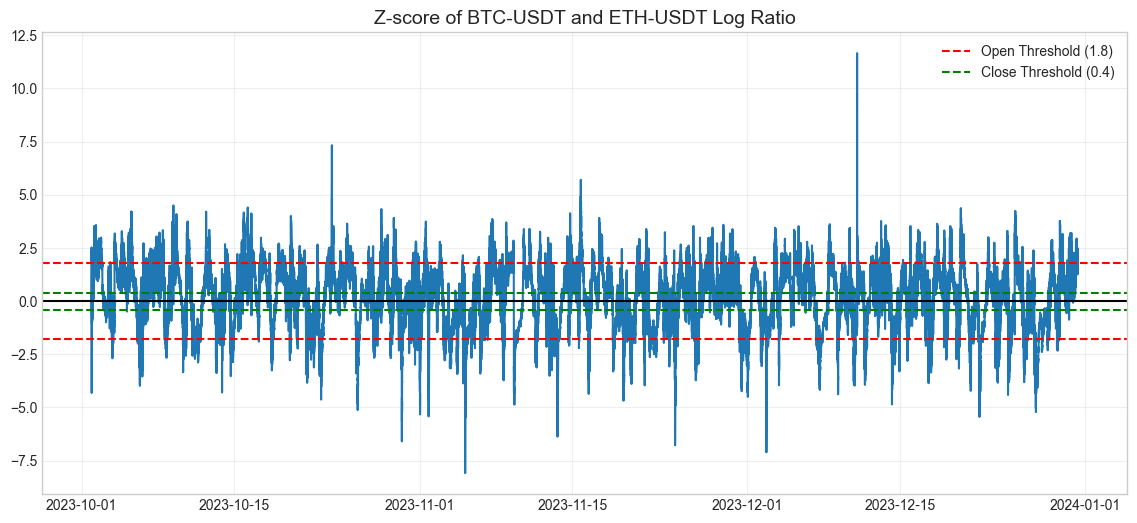

In [10]:
# Calculate z-score with rolling window (as described in the paper)
window_size = 900  # As mentioned in paper
rolling_mean = log_ratio.rolling(window=window_size).mean()
rolling_std = log_ratio.rolling(window=window_size).std()
z_score = (log_ratio - rolling_mean) / rolling_std

# Visualize z-score
plt.figure(figsize=(14, 6))
plt.plot(z_score.dropna())
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1.8, color='r', linestyle='--', label='Open Threshold (1.8)')
plt.axhline(y=-1.8, color='r', linestyle='--')
plt.axhline(y=0.4, color='g', linestyle='--', label='Close Threshold (0.4)')
plt.axhline(y=-0.4, color='g', linestyle='--')
plt.title('Z-score of BTC-USDT and ETH-USDT Log Ratio', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/zscore.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Trading Signal Analysis

Identify potential trading signals based on the z-score thresholds.

Number of potential entry signals: 27100
Number of potential exit signals: 49568
Long entry signals: 11679
Short entry signals: 15421


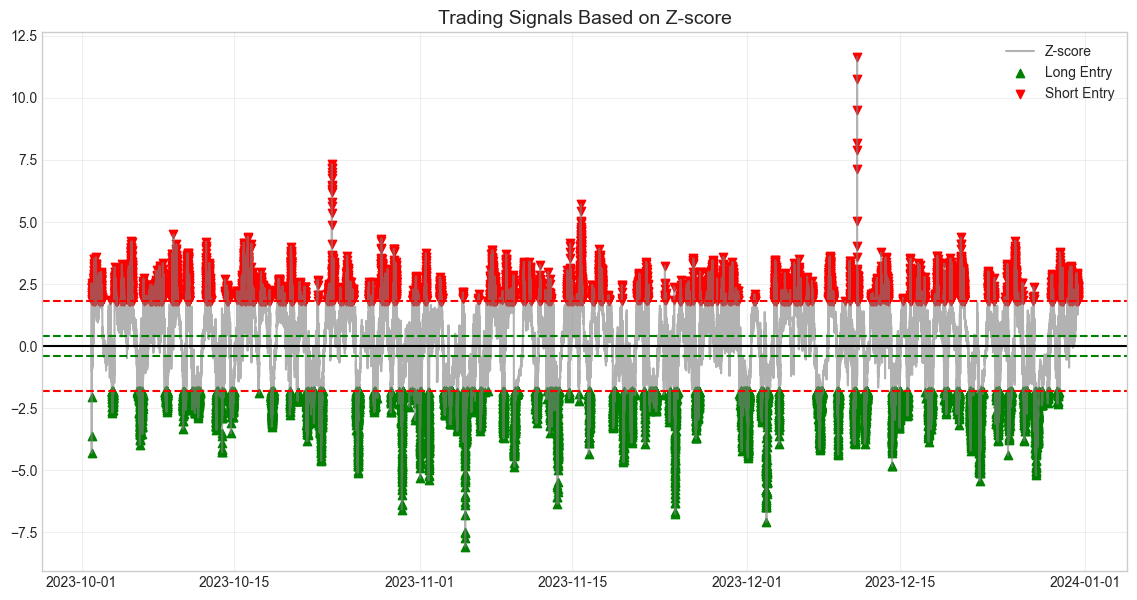

In [11]:
# Analyze potential trading opportunities
trading_zones = pd.DataFrame(index=z_score.dropna().index)
trading_zones['z_score'] = z_score.dropna()
trading_zones['long_entry'] = z_score.dropna() < -1.8  # Long when z-score is below lower threshold
trading_zones['short_entry'] = z_score.dropna() > 1.8  # Short when z-score is above upper threshold
trading_zones['long_exit'] = (z_score.dropna() > -0.4) & (z_score.dropna() < 0.4)  # Exit long when z-score is back in normal range
trading_zones['short_exit'] = (z_score.dropna() > -0.4) & (z_score.dropna() < 0.4)  # Exit short when z-score is back in normal range

# Count potential signals
entry_signals = trading_zones['long_entry'].sum() + trading_zones['short_entry'].sum()
exit_signals = trading_zones['long_exit'].sum() + trading_zones['short_exit'].sum()

print(f"Number of potential entry signals: {entry_signals}")
print(f"Number of potential exit signals: {exit_signals}")
print(f"Long entry signals: {trading_zones['long_entry'].sum()}")
print(f"Short entry signals: {trading_zones['short_entry'].sum()}")

# Distribution of signals over time
plt.figure(figsize=(14, 7))
plt.plot(trading_zones['z_score'], color='gray', alpha=0.6, label='Z-score')
plt.scatter(trading_zones[trading_zones['long_entry']].index, 
            trading_zones[trading_zones['long_entry']]['z_score'],
            color='green', marker='^', label='Long Entry')
plt.scatter(trading_zones[trading_zones['short_entry']].index, 
            trading_zones[trading_zones['short_entry']]['z_score'],
            color='red', marker='v', label='Short Entry')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1.8, color='r', linestyle='--')
plt.axhline(y=-1.8, color='r', linestyle='--')
plt.axhline(y=0.4, color='g', linestyle='--')
plt.axhline(y=-0.4, color='g', linestyle='--')
plt.title('Trading Signals Based on Z-score', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/trading_signals.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Trading Opportunity Distribution

Let's analyze the distribution of trading opportunities over time.

<Figure size 1400x600 with 0 Axes>

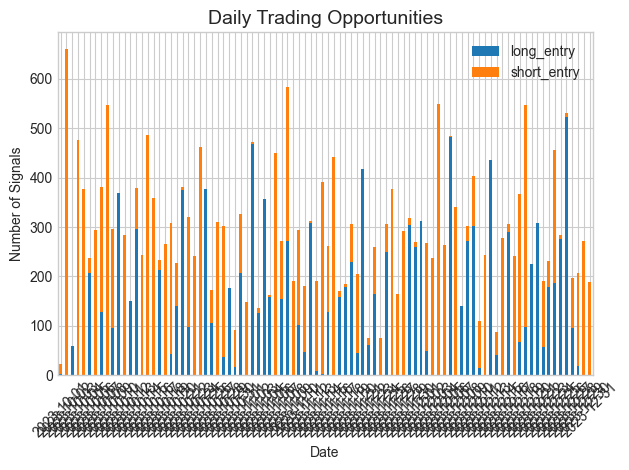

<Figure size 1400x600 with 0 Axes>

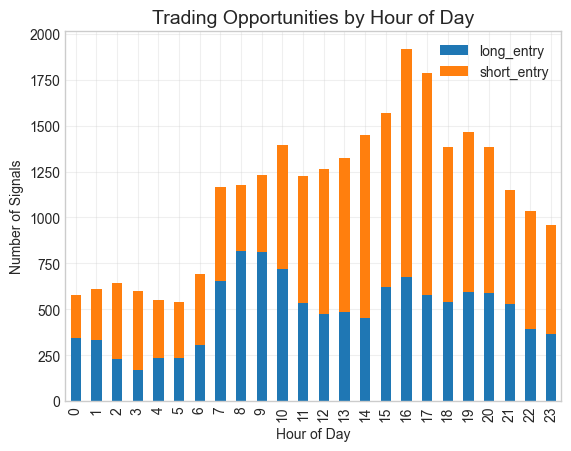

In [12]:
# Group by date to analyze trading opportunities by day
trading_zones['date'] = trading_zones.index.date
daily_opportunities = trading_zones.groupby('date')[['long_entry', 'short_entry']].sum()

# Visualize daily opportunities
plt.figure(figsize=(14, 6))
daily_opportunities.plot(kind='bar', stacked=True)
plt.title('Daily Trading Opportunities', fontsize=14)
plt.ylabel('Number of Signals')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('docs/daily_opportunities.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate opportunity statistics by hour of day
trading_zones['hour'] = trading_zones.index.hour
hourly_opportunities = trading_zones.groupby('hour')[['long_entry', 'short_entry']].sum()

# Visualize hourly opportunities
plt.figure(figsize=(14, 6))
hourly_opportunities.plot(kind='bar', stacked=True)
plt.title('Trading Opportunities by Hour of Day', fontsize=14)
plt.ylabel('Number of Signals')
plt.xlabel('Hour of Day')
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.savefig('docs/hourly_opportunities.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Summary and Next Steps

Based on our exploratory data analysis, let's summarize what we've learned about our BTCUSDT and ETHUSDT pair for trading:

In [13]:
# Summary statistics
summary = {
    'Price Correlation': price_correlation,
    'Returns Correlation': returns_correlation,
    'Cointegration p-value': pvalue,
    'Is Cointegrated (5% level)': pvalue < 0.05,
    'Log Ratio Stationarity p-value': adf_result[1],
    'Is Log Ratio Stationary (5% level)': adf_result[1] < 0.05,
    'Number of Long Entry Signals': trading_zones['long_entry'].sum(),
    'Number of Short Entry Signals': trading_zones['short_entry'].sum(),
    'Trading Days Covered': len(daily_opportunities),
    'Mean BTC/ETH Ratio': price_ratio.mean(),
    'BTC/ETH Ratio Std Dev': price_ratio.std()
}

# Convert to DataFrame for nice display
summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
display(summary_df)

,Metric,Value
0,Price Correlation,0.978259
1,Returns Correlation,0.330113
2,Cointegration p-value,0.04133
3,Is Cointegrated (5% level),True
4,Log Ratio Stationarity p-value,0.023522
5,Is Log Ratio Stationary (5% level),True
6,Number of Long Entry Signals,11679
7,Number of Short Entry Signals,15421
8,Trading Days Covered,92
9,Mean BTC/ETH Ratio,18.363921


### Next Steps:

1. **Traditional Pair Trading Implementation**: Implement a traditional pair trading strategy using fixed thresholds as a baseline.

2. **Reinforcement Learning Environment**: Design an RL environment for pair trading as described in the paper, including:
   - Observation space: Position, Spread, and Zone
   - Action space: Continuous value between -1 and 1 for investment quantity
   - Reward structure: Portfolio reward, action reward, and transaction punishment

3. **RL Model Training**: Train different RL models (A2C, PPO, DQN) and compare their performance.

4. **Performance Evaluation**: Compare the performance of traditional pair trading vs. RL-based approaches.

5. **Hyperparameter Tuning**: Optimize the models' performance through hyperparameter tuning.